In [1]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat, C_origin
from dataset.dataset_config import converted_nodes, converted_edges, river_info # only for visualization
from dataset.traffic_dataset import TrafficDataset
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from utils.visualization import plot_mape_violin, visualize_predictions, add_tod_dow, plot_city_edge_mape, plot_dow_mape_violin_filtered

from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT, STAEformer
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased, STLinear_SPE, compute_spe_torch


c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [2]:
def generate_model(models, train_loader, aux_tensor, DEVICE, SAVE_DIR, load=False):

    for name, ModelClass in models.items():
        # (1) 배치 데이터에서 차원 정보 추출
        x_sample, y_sample = next(iter(train_loader))
        _, T, E, D_in = x_sample.shape
        _, _, _, D_out = y_sample.shape
        n_pred = y_sample.size(1)

        # (2) 모델 인스턴스화
        if name == "MLPBASED":
            model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                            hidden_dim=256, dropout=0.1)
        else:
            # GCNMLP, DCRNN, STGCN 공통 생성자 인자
            kwargs = dict(
                num_nodes=E, node_feature_dim=D_in,
                pred_node_dim=D_out, n_pred=n_pred,
                encoder_embed_dim=32, encoder_depth=1,
                dropout=0.1
            )
            if name == "DCRNN":
                kwargs.update(K=2)
            elif name == "STGCN":
                kwargs.update(kernel_size=3, K=2)
            elif name == "GCNMLP":
                kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
            elif name == "STGAT":
                kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
            elif name == "STGCNWithAux":
                kwargs = dict(
                        num_nodes=E,
                        node_feature_dim=5,
                        pred_node_dim=3,
                        encoder_embed_dim=32,
                        aux_embed_dim=32,
                        aux_data=aux_tensor,
                )
            elif name == "STLinear_h1":
                kwargs = dict(num_nodes=50,
                        kernel_size=33,
                        num_layers=6, 
                        num_heads=1,
                        dropout=0.14
                )
            elif name == "STLinear":
                kwargs = dict(num_nodes=50,
                        kernel_size=33,
                        num_layers=6, 
                        num_heads=8,
                        dropout=0.05925151508866461
                )
            elif name == "STLinear_HopBiased":
                kwargs = dict(
                        num_nodes            = 50,    # 엣지 수
                        kernel_size          = 33,    # 시계열 분해 커널 크기
                        in_steps             = 12,    # 입력 시점 길이
                        out_steps            = 3,     # 예측 시점 길이
                        steps_per_day        = 480,   # 하루 스텝 수
                        input_dim            = 3,     # volume/density/flow
                        output_dim           = 3,     # 예측 채널
                        input_embedding_dim  = 24,    # traffic → 24차원 임베딩
                        tod_embedding_dim    = 24,    # time-of-day 임베딩
                        dow_embedding_dim    = 24,    # day-of-week 임베딩
                        spatial_embedding_dim= 0,     # 원본에서는 사용 안 함
                        adaptive_embedding_dim= 80,   # adaptive embedding 크기
                        feed_forward_dim     = 256,   # FFN hidden dim
                        num_heads            = 2,     # max_hop + 1 = 2, 순수 어텐션 + 홉 bias
                        num_layers           = 6,     # 블록 반복 횟수
                        dropout              = 0.14,  # 드롭아웃 비율
                        use_mixed_proj       = True   # 마지막 예측용 Projection
                    )
            elif name == "STLinear_SPE":
                kwargs = dict(
                        num_nodes=50,            # E
                        kernel_size=33,          # 시계열 분해 커널
                        in_steps=12,             # 과거 입력 스텝 (기본)
                        out_steps=3,             # 예측 스텝 (기본)
                        steps_per_day=480,       # 하루 스텝 수 (기본)
                        input_dim=3,             # volume/density/flow
                        output_dim=3,            # 예측 채널
                        # ────────────────────────────────────────
                        # STLinear_h1과 동일한 임베딩 크기
                        input_embedding_dim=24,  # STLinear 기본
                        tod_embedding_dim=24,
                        dow_embedding_dim=24,
                        spatial_embedding_dim=0, # 원본 STLinear_h1에서는 사용 안 함
                        adaptive_embedding_dim=80,
                        # ────────────────────────────────────────
                        # SPE 관련
                        spe_dim=32,              # 고유벡터 개수 (p)
                        spe_out_dim=96,          # SPE → 투영 차원
                        normalized_laplacian=False,
                        # ────────────────────────────────────────
                        # 공간 블록 설정 (STLinear_h1과 동일)
                        feed_forward_dim=256,    # Self-Attention FFN hidden dim
                        num_heads=1,             # max_hop+1 = 1
                        num_layers=6,            # 블록 반복 횟수
                        dropout=0.14,            # 드롭아웃 비율
                        use_mixed_proj=True
                )
            elif name=="STAEformer":
                kwargs = dict(
                        num_nodes=50,               # 예: E 또는 데이터에서 불러온 노드 수
                        in_steps=12,                 # 예: 12
                        out_steps=3,               # 예: 3
                        steps_per_day=480,       # 예: 480
                        input_dim=3,               # 예: 3
                        output_dim=3,             # 예: 3
                        input_embedding_dim    = 32,
                        tod_embedding_dim      = 32,
                        dow_embedding_dim      = 32,
                        spatial_embedding_dim  = 32,
                        adaptive_embedding_dim = 32,
                        feed_forward_dim       = 256,
                        num_heads       = 1,
                        num_layers      = 4,
                        dropout         = 0.073,
                        use_mixed_proj  = True
                )

            model = ModelClass(**kwargs)

        model = model.to(DEVICE)

    if load == True:
        # (2) 가중치 로드 (임시. 나중에 수정해야 함.)
        if name == "STGCNWithAux":
            ckpt_path = os.path.join(SAVE_DIR, f"STGCNWithAux_epoch033_val0.7441.pth")
        else:
            ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
        model = model.to(DEVICE)
    return model

In [3]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [4]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 256
EPOCHS = 100
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# seed=42
# torch.manual_seed(seed)
# np.random.seed(seed)
# if torch.cuda.is_available():
#     # 현재 GPU에 대한 시드 고정
#     torch.cuda.manual_seed(seed)
#     # 다중 GPU 환경에서도 모두 같은 시드 고정
#     torch.cuda.manual_seed_all(seed)

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

aux_data = np.load('dataset/traffic_dataset_13_aux_smoothen.npy') # (T_aux_total, E, C) (10080, 50, 3)
aux_tensor = torch.from_numpy(aux_data).float().to(DEVICE)

# 2) SPE 텐서 계산 (NumPy 인접행렬 → SPE)
spe_dim = 32
spe_tensor = compute_spe_torch(edge_adj_mat, spe_dim, normalized=True)  # (E, p)
spe_tensor = spe_tensor.to(DEVICE)

In [14]:
# 공통 파라미터 및 모델 목록 정의

DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "DCRNN":     DCRNN,
#    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
#    "STGCNWithAux": STGCNWithAux,
#    "STAEformer": STAEformer,
    "STLinear_h1": STLinear,
#    "STLinear_HopBiased": STLinear_HopBiased,
#    "STLinear_SPE": STLinear_SPE
}

In [ ]:
# generate model instance
model = generate_model(models, train_loader, aux_tensor, DEVICE, SAVE_DIR)

# Training
# (3) 옵티마이저·손실함수 설정
weight_decay = 1e-5
LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
criterion = torch.nn.L1Loss()

# (4) Trainer 초기화·학습
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=DEVICE,
    auto_save=True,
    save_dir=SAVE_DIR
)
trainer.fit()

이어서 학습하기

In [65]:
# trainer.get_history()로 얻은 history를 Trainer에 load하면 그래프도 이어서 그려줍니다. 

history = trainer.get_history()

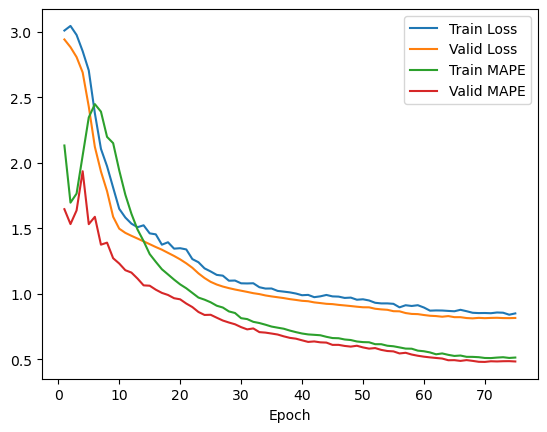

Early stopping at epoch 75


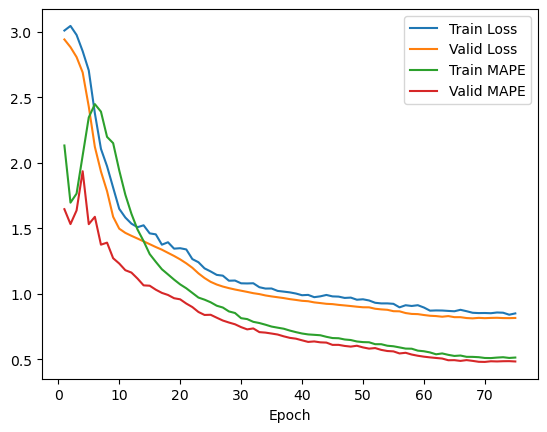

In [66]:
# 1) Trainer 준비 (epochs=N 은 "추가 학습할 epoch 수")
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
trainer = Trainer(
    model, train_loader, valid_loader,
    optimizer, criterion,
    epochs=30, device=DEVICE,
    auto_save=True, save_dir="./checkpoints",
    early_stopping_patience=5

)

# 2) 외부에서 미리 로드한 가중치·history가 있으면
trainer.load_checkpoint(
    state_dict   = torch.load("./checkpoints/GCNMLP_epoch068_val0.8127.pth"),
    history      = history
)

# 3) 이어서 학습
trainer.fit()

로드 및 시각화

In [15]:
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드
# ─────────────────────────────────────────────────────────
model = generate_model(models, train_loader, aux_tensor, DEVICE, SAVE_DIR, load=True)


--- Visualizing STAEformer ---


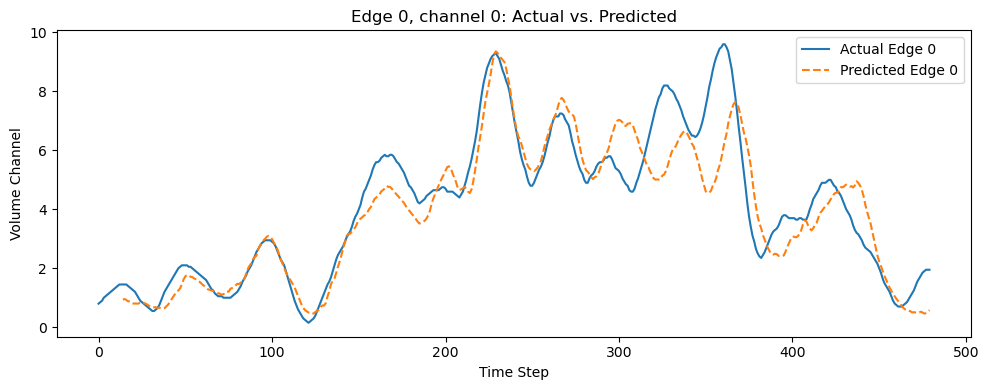

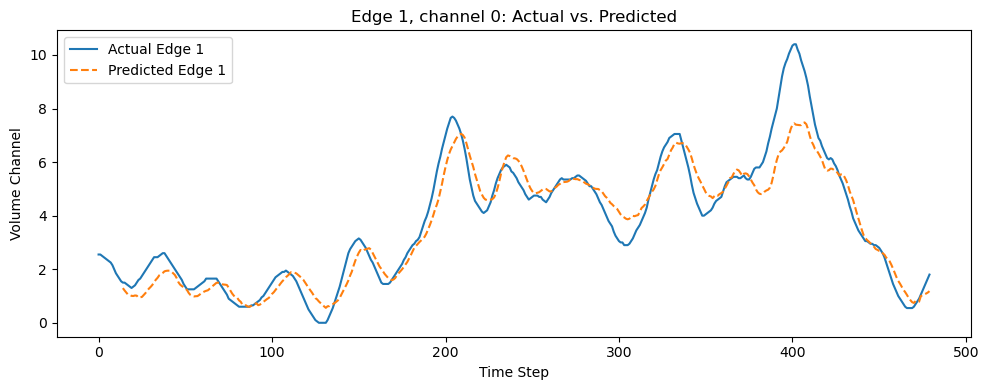

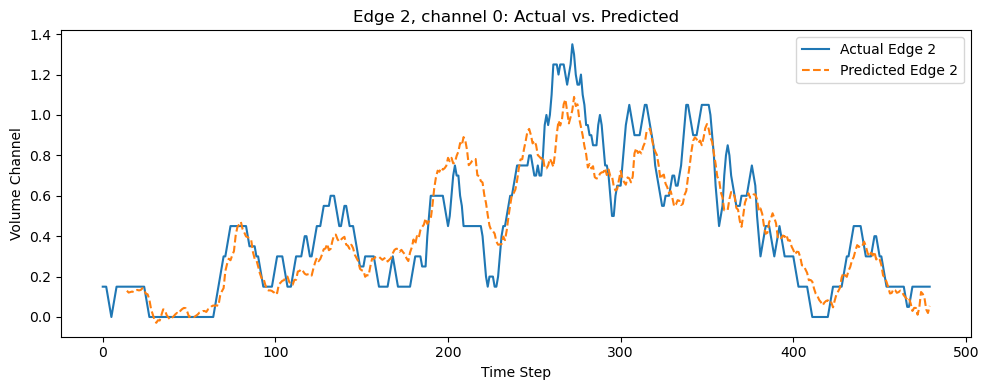

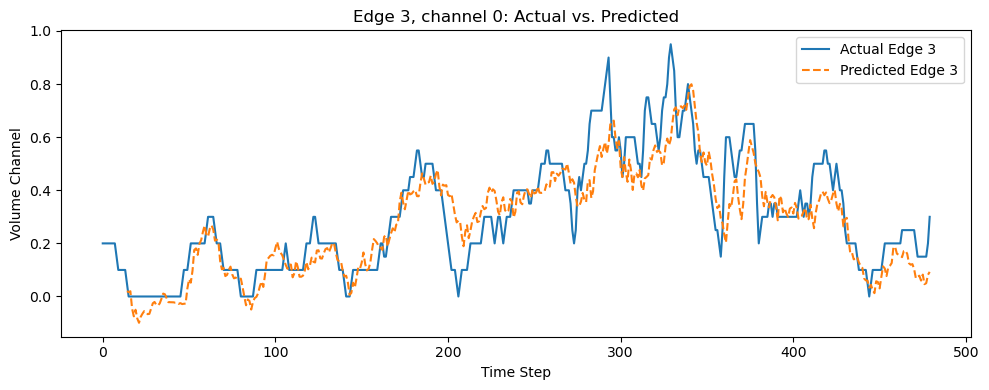

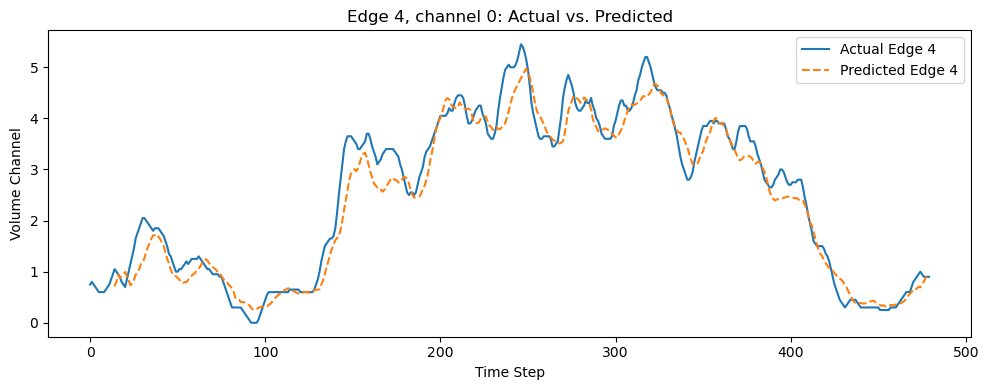

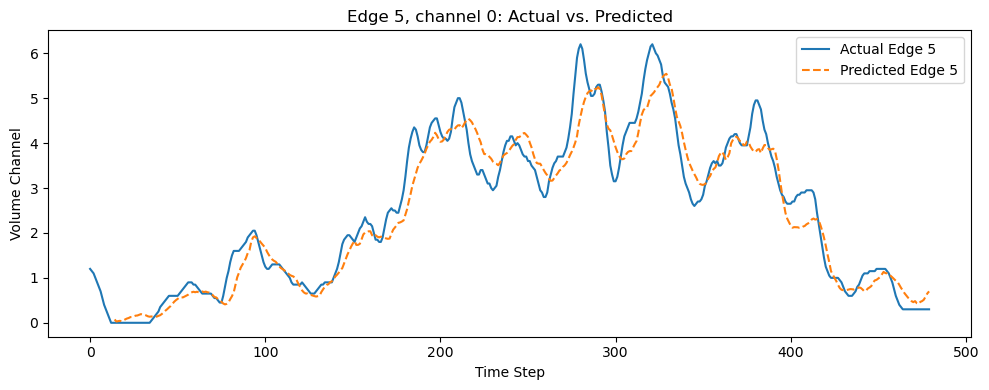

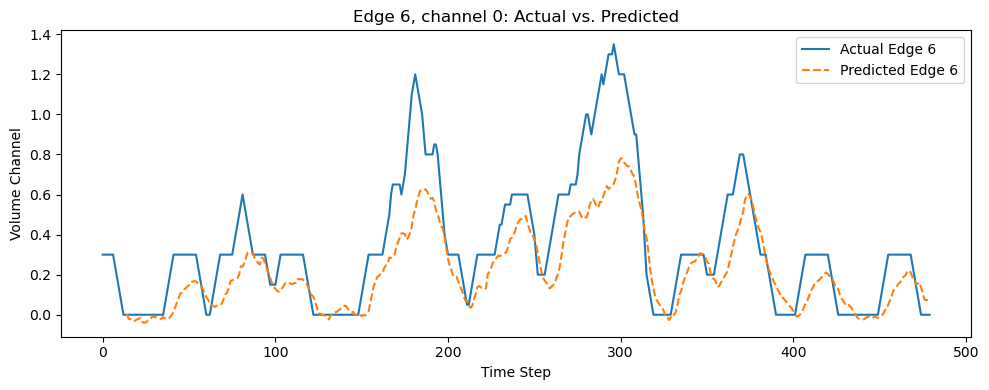

In [13]:
model.to(DEVICE)
name = model.__class__.__name__
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [0,1,2,3,4,5,6]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [16]:
calculate_performance_index(model, valid_loader, torch.nn.MSELoss(), DEVICE, EDGE_INDEX, EDGE_ATTR)

Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

Dataset size: 3337 samples
Average Loss (L2/MSE): 6.6888
Average MAPE:         0.4169
Average MAE:          0.6837
Average RMSE:         2.5863


Step-wise MAPE:
  +3: mean=0.2781, std=0.0614
  +6: mean=0.4440, std=0.0619
  +12: mean=0.5584, std=0.0697
Channel-wise MAPE:
  volume: mean=0.3465, std=0.0533
  density: mean=0.5788, std=0.0886
  flow: mean=0.3548, std=0.0481
Overall MAPE: mean=0.4268, std=0.1291


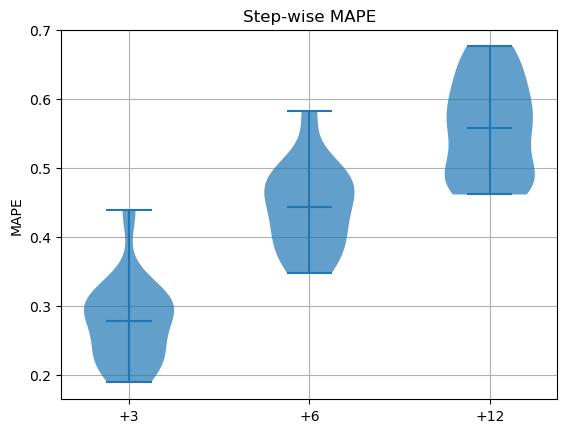

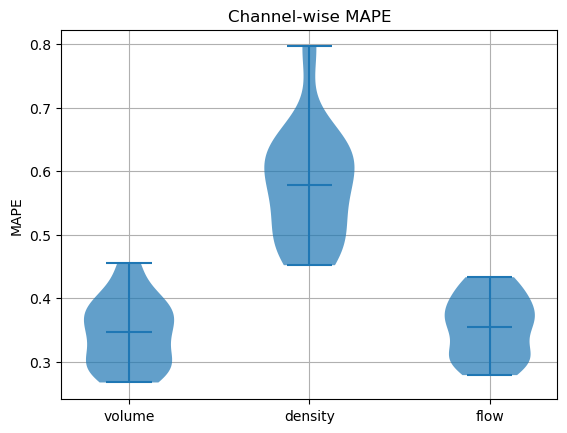

In [17]:
# 모델, loader, device, edge_index, edge_attr 준비 후
plot_mape_violin(model, valid_loader, DEVICE, edge_index, edge_attr)


100%|██████████| 53/53 [00:07<00:00,  7.29it/s]


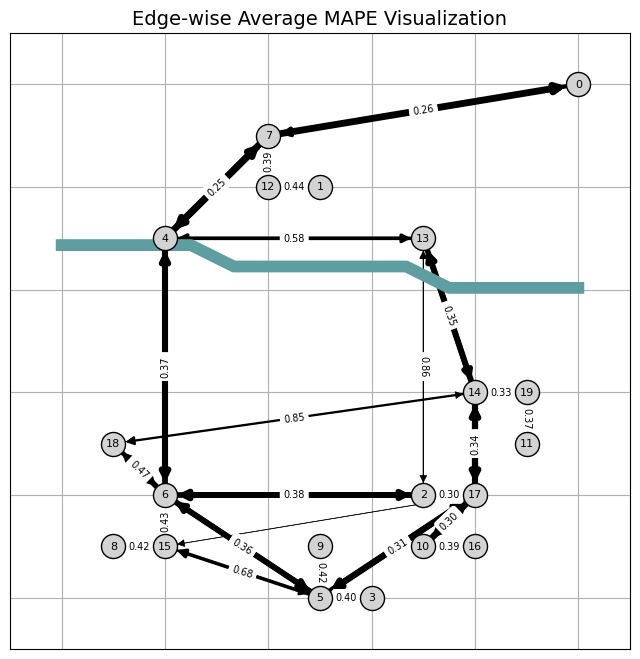

In [ ]:
plot_city_edge_mape(
    converted_nodes, converted_edges, river_info,
    valid_loader, model, DEVICE,
    edge_index, edge_attr,
    city_size=10
)


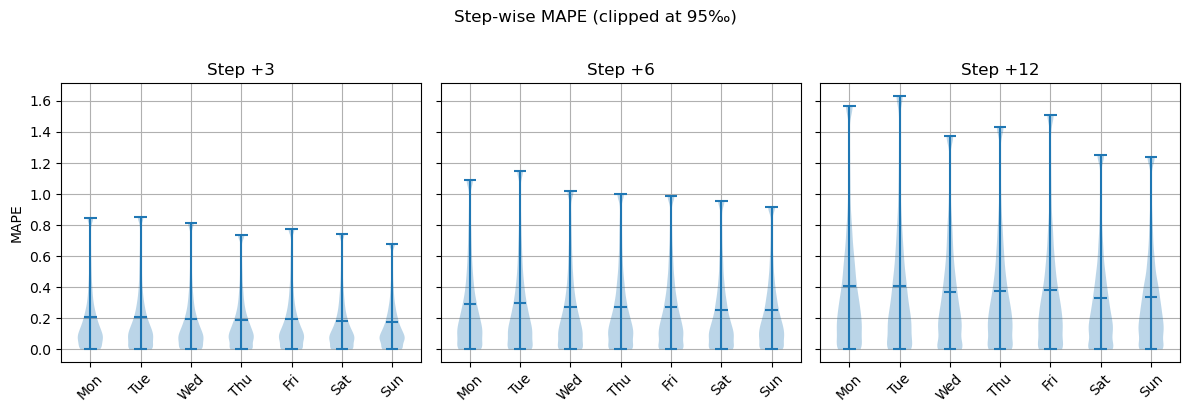

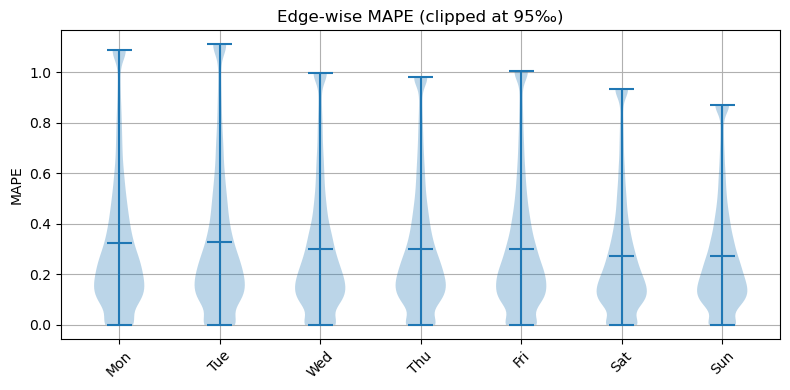

In [104]:
# valid_loader, model, DEVICE, edge_index, edge_attr 준비 후
plot_dow_mape_violin_filtered(
    valid_loader, model, DEVICE,
    edge_index, edge_attr,
    dow_idx=4,            # DOW 채널 인덱스
    clip_percentile=95    # 상위 5% 이상은 잘라냄
)
